# DFO Code Sample for Imputation

Tor Kitching
December 12, 2022
Conda Env: pymc3_env

## Setup

In [1]:
import requests
import pandas as pd
import random
import numpy as np
import math
import scipy
import numpy.ma as ma
from matplotlib import pyplot as plt
import matplotlib as mpl
import statistics
import seaborn as sns
import pymc as pm
import arviz as az

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def label_month (row):
      if row['Month'] == 'January': # immature
        return 1
      if row['Month'] == 'February': # immature
        return 2
      if row['Month'] == 'March': # immature
        return 3
      if row['Month'] == 'April': # immature
        return 4
      if row['Month'] == 'May': # immature
        return 5
      if row['Month'] == 'June': # immature
        return 6
      if row['Month'] == 'July': # immature
        return 7
      if row['Month'] == 'August': # immature
        return 8
      if row['Month'] == 'September': # immature
        return 9
      if row['Month'] == 'October': # immature
        return 10
      if row['Month'] == 'November': # immature
        return 11
      return 12

In [3]:
#import matplotlib.pylab as pylab
#params = {'legend.fontsize': 'x-large',
#          'figure.figsize': (14, 5),
#         'axes.labelsize': 'x-large',
#         'axes.titlesize':'x-large',
#         'xtick.labelsize':'x-large',
#         'ytick.labelsize':'x-large'}
#pylab.rcParams.update(params)

## Data Calls

In [4]:
River_temp = pd.read_csv("River_temperatures_blank.csv")

Air_temp = pd.read_csv('Air_temperatures_blank.csv')

## Data Cleaning and Initiation

In [5]:
River_temp['Month'] = River_temp.apply (lambda row: label_month(row), axis=1)

# Type conversions
River_temp['Month'] = River_temp['Month'].astype(str).astype(float)
River_temp['Year of fishing'] = River_temp['Year of fishing'].astype(str).astype(float)

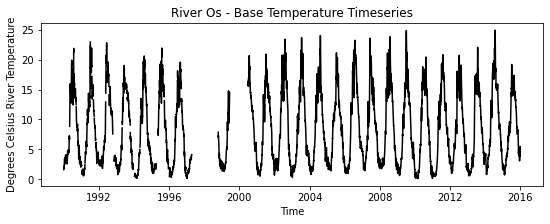

In [6]:
River_temp = River_temp.rename(columns={"Year of fishing": "Year", "Day nr.": "Day"})
River_temp['date'] = pd.to_datetime(River_temp[['Day','Month','Year']],errors='coerce')
plt.figure(figsize=(9,3))
plt.plot(River_temp['date'], River_temp['temperature'], color='black')
plt.xlabel('Time')
plt.ylabel('Degrees Celsius River Temperature')
plt.title('River Os - Base Temperature Timeseries');
#plt.savefig('BaseTemperature_Os_.pdf', bbox_inches='tight');

In [7]:
River_temp = River_temp.rename(columns={"Year":"Year of fishing", "Day":"Day nr."})

In [8]:
os_going = pd.merge(River_temp, Air_temp, how='left', left_on= ['Year of fishing','Month','Day nr.'], right_on = ['year', 'month', 'day'])

In [9]:
clean_os = os_going.dropna(subset=['temperature','value'])

The above is to clean out the na's for the model's sake.

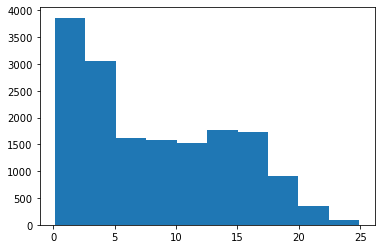

In [10]:
plt.hist(clean_os['temperature']);

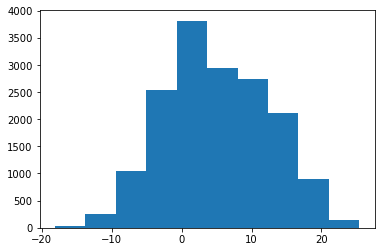

In [11]:
plt.hist(clean_os['value']);

## Model

In [12]:
# setup parameters for temperature relationships
x_ = np.asarray(clean_os['value'])

y_ = np.asarray(clean_os['temperature'])

In [13]:
with pm.Model() as linear_o:
    
    a = pm.Normal('a',mu=0, sigma = 5)
    b = pm.Normal('b',mu=0, sigma = 5)
    
    sigma = pm.HalfCauchy('Sigma', 0.5)

    mu_ = a + b*x_
    
    mu_ = mu_*1
    
    y_obs = pm.Normal('y_obs', mu_ , sigma, observed=y_) # n=100, for binomial

In [14]:
with linear_o:
    trace_linear_o = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, Sigma]
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
The acceptance probability does not match the target. It is 0.9217, but should be close to 0.8. Try to increase the number of tuning steps.


## Model Outputs

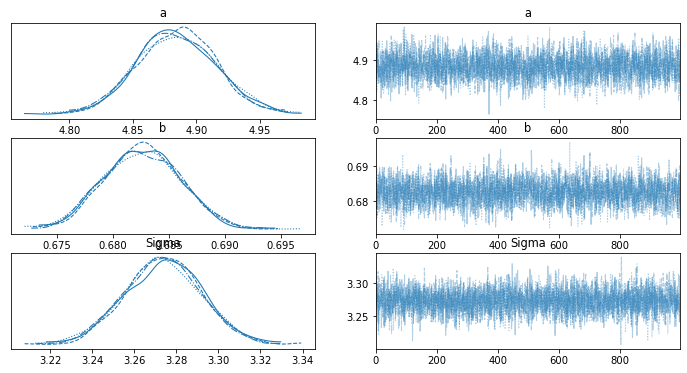

In [15]:
az.plot_trace(trace_linear_o);

In [16]:
az.summary(trace_linear_o, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.88,0.03,4.83,4.94,0.0,0.0,2718.43,2454.70,1.0
b,0.68,0.00,0.68,0.69,0.0,0.0,2806.29,3023.77,1.0
Sigma,3.27,0.02,3.24,3.31,0.0,0.0,3862.53,2575.61,1.0


## Completing the dataset

In [17]:
os_going['temperature'] = os_going.apply(
    lambda row: np.mean(trace_linear_o.posterior.a.values) + np.mean(trace_linear_o.posterior.b.values)*row['value'] 
        if np.isnan(row['temperature']) 
            else row['temperature'],
    axis=1
)

In [18]:
os_going['temperature'].isna().sum()

22

In [19]:
os_going[os_going['temperature'].isna()]

,Month,Day nr.,Year of fishing,temperature,date,year,month,day,value
118,2.0,29,1990.0,NaN,NaT,NaN,NaN,NaN,NaN
849,2.0,29,1991.0,NaN,NaT,NaN,NaN,NaN,NaN
2312,2.0,29,1993.0,NaN,NaT,NaN,NaN,NaN,NaN
3043,2.0,29,1994.0,NaN,NaT,NaN,NaN,NaN,NaN
3774,2.0,29,1995.0,NaN,NaT,NaN,NaN,NaN,NaN
5237,2.0,29,1997.0,NaN,NaT,NaN,NaN,NaN,NaN
5968,2.0,29,1998.0,NaN,NaT,NaN,NaN,NaN,NaN
6699,2.0,29,1999.0,NaN,NaT,NaN,NaN,NaN,NaN
8162,2.0,29,2001.0,NaN,NaT,NaN,NaN,NaN,NaN
8893,2.0,29,2002.0,NaN,NaT,NaN,NaN,NaN,NaN


## Visualization

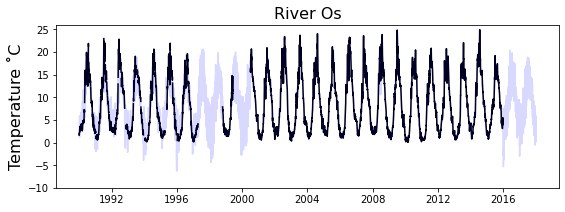

In [20]:
plt.figure(figsize=(9,3))
plt.plot(River_temp['date'], River_temp['temperature'], color='black')
plt.plot(os_going['date'], os_going['temperature'], color='blue', alpha = 0.15)
plt.ylabel('Temperature ˚C', fontsize = 16)
plt.title('River Os', fontsize = 16)
plt.ylim(-10, 26)

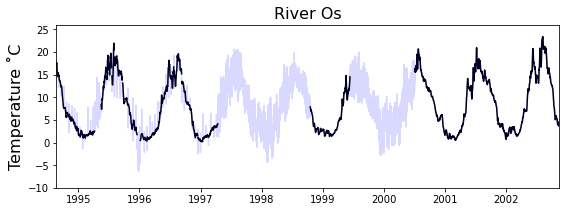

In [21]:
plt.figure(figsize=(9,3))
plt.plot(River_temp['date'], River_temp['temperature'], color='black')
plt.plot(os_going['date'], os_going['temperature'], color='blue', alpha = 0.15)
plt.ylabel('Temperature ˚C', fontsize = 16)
plt.title('River Os', fontsize = 16)
plt.ylim(-10, 26)
plt.xlim(9000,12000)